### Part 1:  Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. You can view it at `examples/1D-SLAM.ipynb`. Your first task is to code this from scratch.

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct it is using `jax`'s `jacobian`. Its usage is explained in the supplementary notebook (`examples/`).

### How to get started?

1. Go through the example and understand the optimization procedure.
2. Generate the data as in the example.
3. Write the derivatives of the function with respect to the constraints
4. Create the final jacobian and write the update steps using Gauss Newton

This tiny example will help make sense of the next question, as it's largely just an extension of this.

Finally, plot the loop closure constraint, poses, and error at every iteration as well. Since this is a one dimensional example, you can just assume x = y.

In [2]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt



Ground truth states, x_gt = [0. 1. 2. 3. 0.]
Odometry states, x_odom = [0.  1.1 2.1 3.2 0.5]
variance matrix: 
[[0.01  0.    0.    0.    0.    0.   ]
 [0.    0.01  0.    0.    0.    0.   ]
 [0.    0.    0.01  0.    0.    0.   ]
 [0.    0.    0.    0.01  0.    0.   ]
 [0.    0.    0.    0.    0.01  0.   ]
 [0.    0.    0.    0.    0.    0.001]]
Confidence Matrix: 
[[ 100.    0.    0.    0.    0.    0.]
 [   0.  100.    0.    0.    0.    0.]
 [   0.    0.  100.    0.    0.    0.]
 [   0.    0.    0.  100.    0.    0.]
 [   0.    0.    0.    0.  100.    0.]
 [   0.    0.    0.    0.    0. 1000.]]
Initialization of f(x) = [ 0.   0.   0.   0.  -0.5  0. ]
Jacobian is: 
[[ 1 -1  0  0  0]
 [ 0  1 -1  0  0]
 [ 0  0  1 -1  0]
 [ 0  0  0  1 -1]
 [ 1  0  0  0 -1]
 [ 1  0  0  0  0]]
H = 
[[1200. -100.    0.    0. -100.]
 [-100.  200. -100.    0.    0.]
 [   0. -100.  200. -100.    0.]
 [   0.    0. -100.  200. -100.]
 [-100.    0.    0. -100.  200.]]
b = [-50.   0.   0.   0.  50.]
K =
[[ 0.00000000

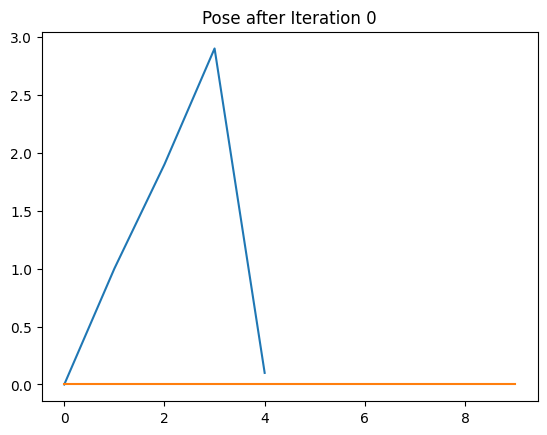

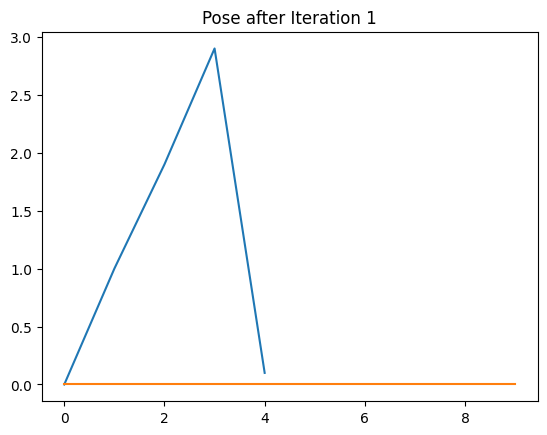

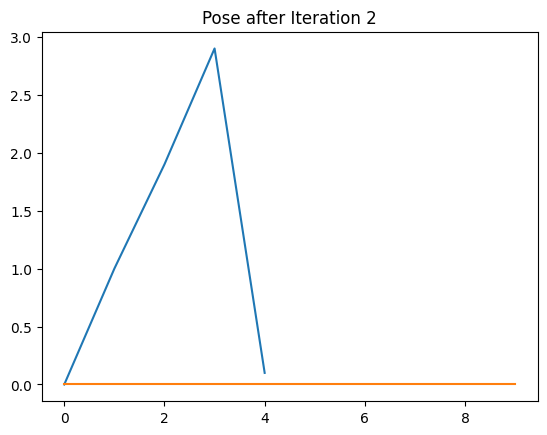

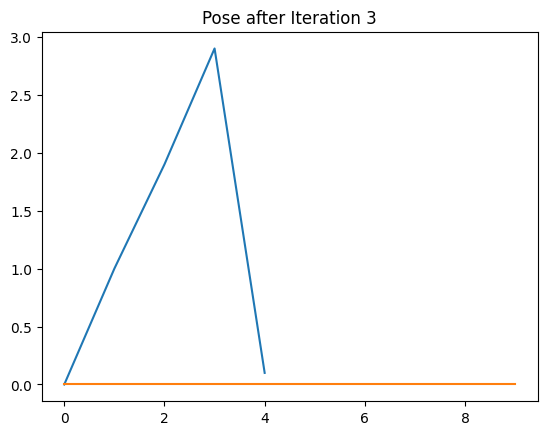

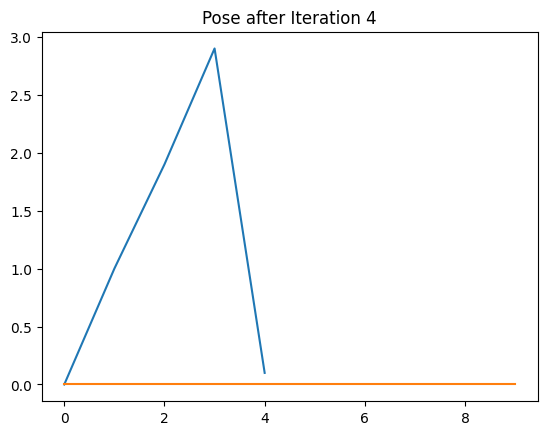

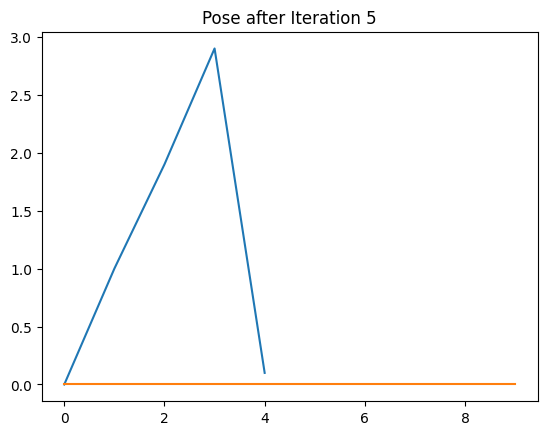

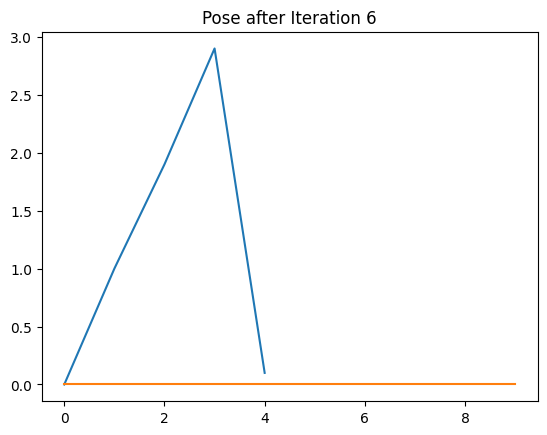

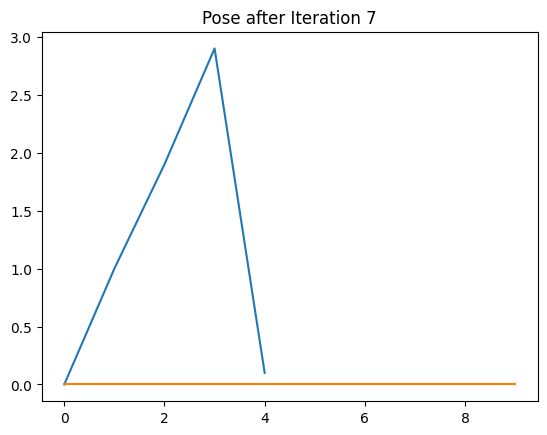

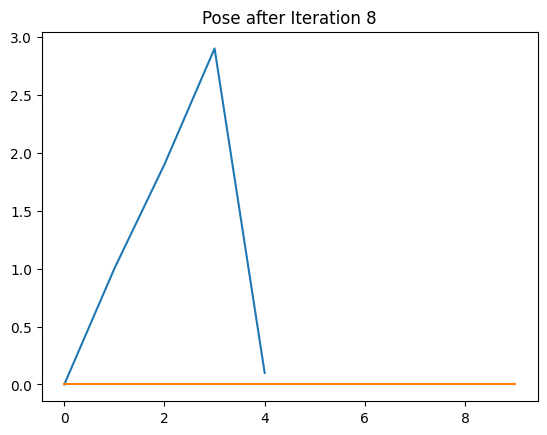

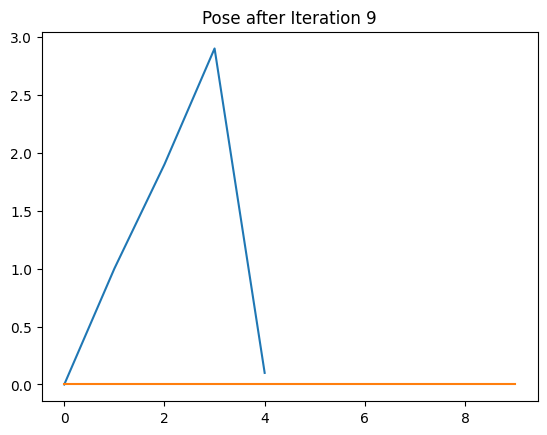

Initial Residual = [ 0.   0.   0.   0.  -0.5  0. ]
Final Residual = [ 1.0000000e-01  1.0000000e-01  1.0000000e-01  1.0000000e-01
 -1.0000000e-01 -3.4666739e-33]
Final states: [-0.   1.   1.9  2.9  0.1]


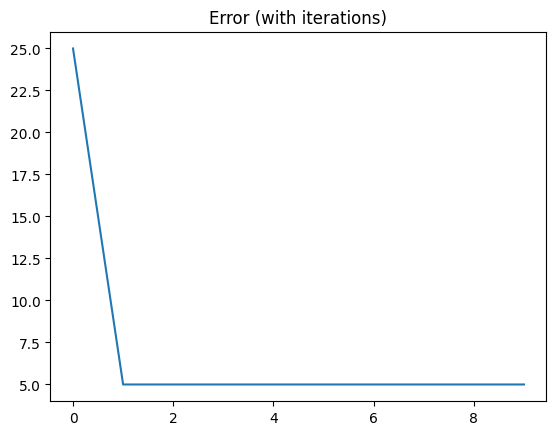

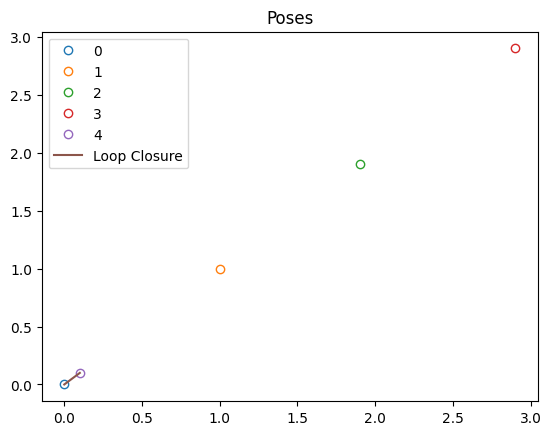

In [13]:
# Generating the Data

# Ground Truth
ground_truth = np.array([1.0, 1.0, 1.0, -3.0, 0.0])

# Odometry Measurement
odometry = np.array([1.1, 1.0, 1.1, -2.7, 0.0])

# Define the robot motion model function
def motion_model(x, u):
    return x + u


# Define the initial estimate of robot poses
x_gt = np.array([0.0])
x_odo = np.array([0.0])

# Finding the next states
for gt, odo in zip(ground_truth,odometry):
    x_gt = np.append(x_gt,(motion_model(gt,x_gt[-1])))
    x_odo = np.append(x_odo,(motion_model(odo,x_odo[-1])))


# Remove the last state, which represents the loop closure constraint
x_gt = x_gt[:-1]
x_odo = x_odo[:-1]

x_gt = np.array(x_gt)
x_odo = np.array(x_odo)

print(f"Ground truth states, x_gt = {x_gt}")
print(f"Odometry states, x_odom = {x_odo}")


variance_odom = 0.01        
variance_loop_closure = 0.01           # varianceiance for loop closure condition
variance_initial = 0.001     
no_odom, no_lc = 4, 1
variance_vector = [variance_odom] * no_odom + [variance_loop_closure] * no_lc + [variance_initial]
variance_vector = np.array(variance_vector)

# Variance Matrix
variance_matrix = np.diag(variance_vector) 
print(f"variance matrix: \n{variance_matrix}")

# Confidence Matrix
conf_matrix = np.diag(1/variance_vector)
print(f"Confidence Matrix: \n{conf_matrix}")

# Function for constraints
def f_x(x, u):
    
    x0, x1, x2, x3, x4 = x
    u0, u1, u2, u3, u04 = u

    v = np.array([
        motion_model(u0, x0) - x1,
        motion_model(u1, x1) - x2,
        motion_model(u2, x2) - x3,
        motion_model(u3, x3) - x4,
        motion_model(u04, x0) - x4,
        x0 - 0
    ])
    return v

f_x0 = f_x(x_odo,odometry)
print(f"Initialization of f(x) = {f_x0}")


# Jacobian
jacobian = np.array([
    [1, -1, 0, 0, 0],
    [0, 1, -1, 0, 0],
    [0, 0, 1, -1, 0],
    [0, 0, 0, 1, -1],
    [1, 0, 0, 0, -1],
    [1, 0, 0, 0, 0]
])
print(f"Jacobian is: \n{jacobian}")

jacobian_transpose = np.transpose(jacobian)
conf_matrix_transpose = np.transpose(conf_matrix)

# H = J^(T)*Omega*J
H = np.dot(np.dot(jacobian_transpose,conf_matrix), jacobian)

print("H = ")
print(H)

b = np.dot(np.dot(jacobian_transpose,conf_matrix_transpose),f_x0)
print(f"b = {b}")

K = K = np.dot(np.dot(-np.linalg.inv(H),jacobian_transpose) ,conf_matrix)
print("K =")
print(K)


i = 10   # Number of iterations
x_vect = np.array(x_odo).reshape(-1, 1)
u_vect = np.array(odometry).reshape(-1, 1)

# Logs
cost = []  # History of Mahalanobis Costs
v_cost = []     # History of 'v' vector

# Gauss Newton updates
for _ in range(i):
    # Calculate cost
    v = f_x(x_vect, u_vect).reshape(-1, 1)
    v_cost.append(v.flatten())
    # mls_cost = float(np.dot(np.dot(v.T , conf_matrix) , v))
    mls_cost = float(np.dot(np.dot(v.T , conf_matrix) , v).item())
    cost.append(mls_cost)  # Log cost
    # Updates
    del_x = np.dot(K,v)
    x_vect = x_vect + del_x

    x_range = list(range(i))

    # Plot intermediate poses
    plt.plot(x_vect)
    plt.plot(x_range, [0] * i)
    plt.title(f'Pose after Iteration {_}')
    plt.show()


x_final = x_vect.flatten()

print(f"Initial Residual = {f_x0}")
print(f"Final Residual = {f_x(x_final,odometry)}")

plt.figure()
print(f"Final states: {np.around(x_final,3)}")
plt.title("Error (with iterations)")
plt.plot(cost)

# Plots
plt.figure()
plt.title("Poses")
plt.plot(x_final[0], x_final[0], 'o', fillstyle='none', label="0")
plt.plot(x_final[1], x_final[1], 'o', fillstyle='none', label="1")
plt.plot(x_final[2], x_final[2], 'o', fillstyle='none', label="2")
plt.plot(x_final[3], x_final[3], 'o', fillstyle='none', label="3")
plt.plot(x_final[4], x_final[4], 'o', fillstyle='none', label="4")
plt.plot([x_final[0], x_final[4]], [x_final[0], x_final[4]], 
    label="Loop Closure")
plt.legend()

# plt.figure()
# # Assuming you have the 
# loop closure constraints in `x_odo`
# loop_closure_constraints = x_odo[-1]

# # Plot loop closure constraints
# plt.figure()
# plt.plot(loop_closure_constraints, 'o', fillstyle='none', label="Loop Closure")
# plt.title("Loop Closure Constraints")
# plt.legend()
# plt.show()